In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..\..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

from jaxfin.models.gbm import MultiGeometricBrownianMotion

from src.spread import v_margrabe, margrabe_deltas, margrabe

SEED = 42

In [18]:
s0 = jnp.array([100, 100])
means = jnp.array([0.1, 0.1])
vols = jnp.array([0.2, 0.3])
correlation = jnp.array([[1, 0.2], [0.2, 1]], dtype=jnp.float32)

gbm = MultiGeometricBrownianMotion(s0, means, vols, correlation, dtype=jnp.float32)

In [19]:
expiration = 1.0
N = 252
dt = expiration / N
n_simulation = 1

stock_paths = gbm.simulate_paths(SEED, expiration, N, n_simulation)

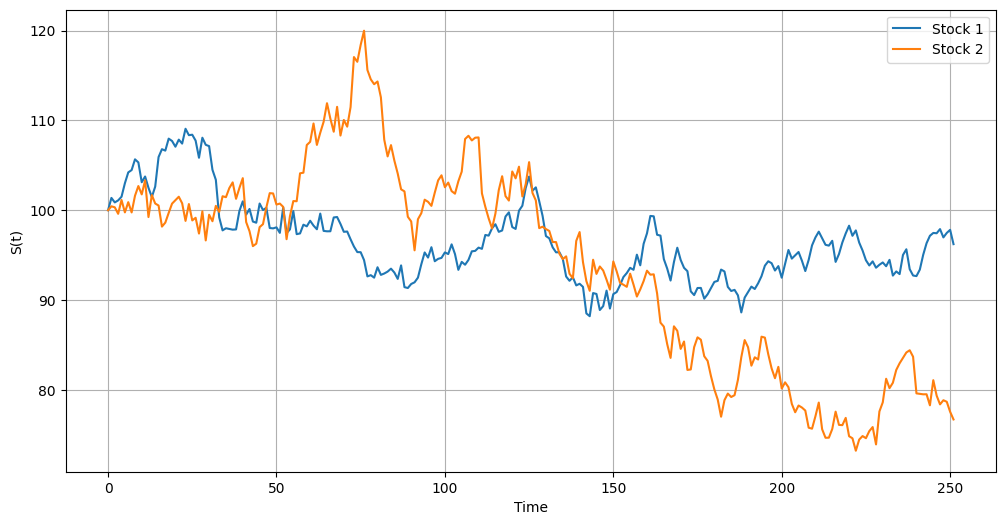

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(stock_paths[:, :, 0], label='Stock 1')
plt.plot(stock_paths[:, :, 1], label='Stock 2')
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.legend()
plt.show()

In [42]:
deltas = jnp.asarray([margrabe_deltas(stock_paths[i, 0, 0], stock_paths[i, 0, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
spread_value = jnp.asarray([margrabe(stock_paths[i, 0, 0], stock_paths[i, 0, 1], expiration- i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
b = [spread_value[0] - deltas[0][0] * stock_paths[0, 0, 0] - deltas[0][1] * stock_paths[0, 0, 1]]
vs = [spread_value[0]]

for i in range(1, N):
    vs.append(deltas[i - 1][0] * stock_paths[i, 0, 0] + deltas[i - 1][1] * stock_paths[i, 0, 1] + b[i -1])
    b.append(vs[i] - deltas[i][0] * stock_paths[i, 0, 0] - deltas[i][1] * stock_paths[i, 0, 1])

hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths[:, 0, 1] - stock_paths[:, 0, 0], 0)

In [43]:
print('The final hedge error is: ', hedge_error[-1])

The final hedge error is:  -0.30664527


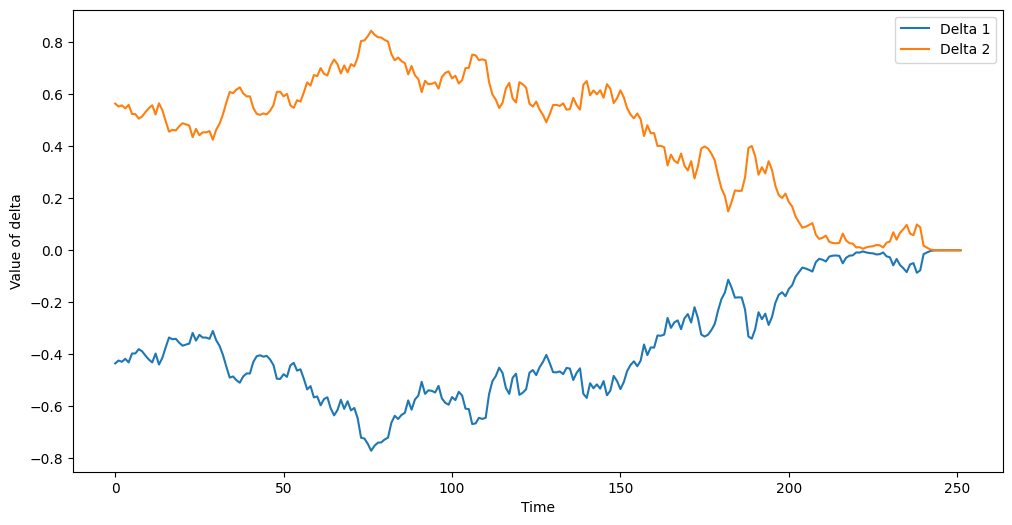

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(deltas[:, 0], label='Delta 1')
plt.plot(deltas[:, 1], label='Delta 2')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value of delta')
plt.show()

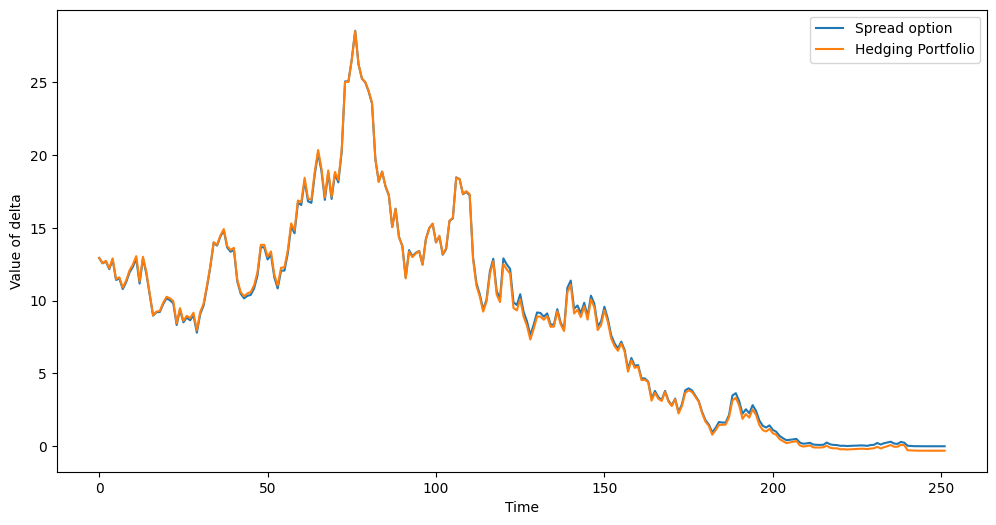

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(spread_value, label='Spread option')
plt.plot(vs, label='Hedging Portfolio')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value of delta')
plt.show()

## Multiple simulations

In [46]:
n_simulation = 1000

stock_paths = gbm.simulate_paths(SEED, expiration, N, n_simulation)

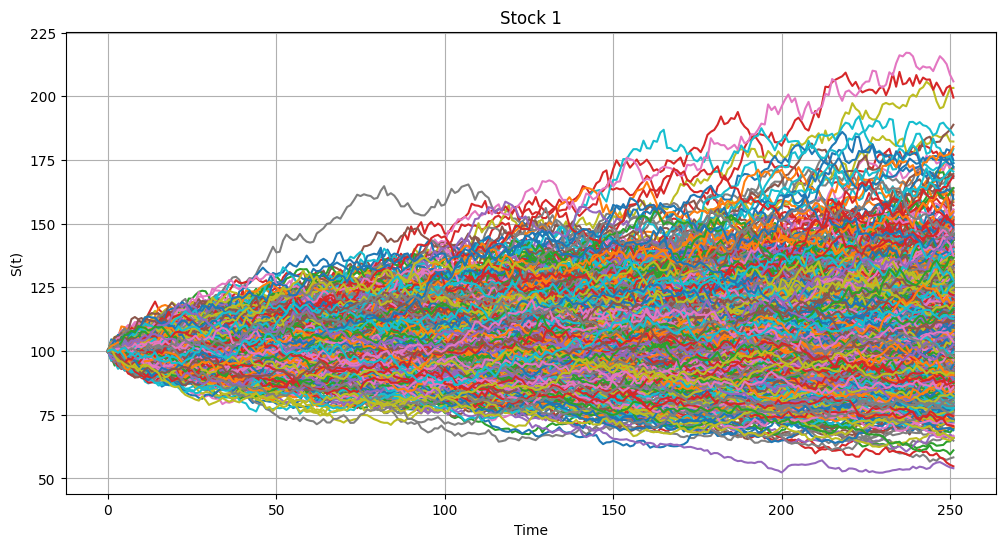

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(stock_paths[:, :, 0])
plt.title('Stock 1')
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

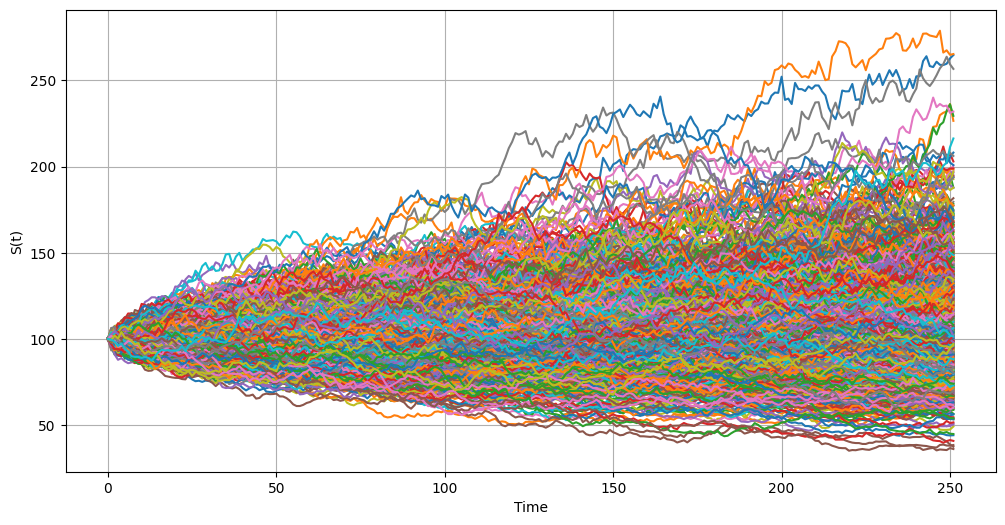

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(stock_paths[:, :, 1])
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

In [57]:
from jax import vmap

In [60]:
vmap_deltas = vmap(margrabe_deltas, in_axes=(0, 0, None, None, None, None))

In [54]:
expirations = expiration - jnp.arange(N) * dt

In [63]:
deltas = jnp.asarray([vmap_deltas(stock_paths[i, :, 0], stock_paths[i, :, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])

In [83]:
spread_value = jnp.asarray([margrabe(stock_paths[i, :, 0], stock_paths[i, :, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])

In [95]:
deltas.shape

(252, 2, 1000)

In [94]:
spread_value.shape

(252, 1000)

In [96]:
stock_paths.shape

(252, 1000, 2)

In [100]:
deltas = jnp.asarray([vmap_deltas(stock_paths[i, :, 0], stock_paths[i, :, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
spread_value = jnp.asarray([margrabe(stock_paths[i, :, 0], stock_paths[i, :, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
b = [spread_value[0, :] - deltas[0, 0, :] * stock_paths[0, :, 0] - deltas[0, 1, :] * stock_paths[0, :, 1]]
vs = [spread_value[0, :]]

for i in range(1, N):
    vs.append(deltas[i - 1, 0, :] * stock_paths[i, :, 0] + deltas[i - 1, 1, :] * stock_paths[i, :, 1] + b[i - 1])
    b.append(vs[i] - deltas[i, 0, :] * stock_paths[i, :, 0] - deltas[i, 1, :] * stock_paths[i, :, 1])

hedge_error = jnp.asarray(vs)[-1] - jnp.maximum(stock_paths[-1:, :, 1] - stock_paths[-1:, :, 0], 0)

In [101]:
hedge_error.shape

(1, 1000)

In [102]:
jnp.mean(hedge_error[-1, :])

Array(0.1402342, dtype=float32)

In [104]:
jnp.std(hedge_error[-1, :]) / spread_value[0, 0]

Array(0.06059172, dtype=float32)